
<base target="_blank">

In our previous blogs, we've discussed how we've gathered, prepared, modeled and plotted data on the whereabouts of wolf pairs and packs in Germany. Our model predicts wolf presence in an area in the coming year, based on a rich geographical dataset we've constructed. This dataset contains the locations where wolves settled in 2000 - 2022 in Germany - our target- and many features that we gathered and prepared on geographical areas in Germany. 

The resulting model is quite good in predicting what areas are attractive and what areas are not for the wolf to be present. In this blog, we go into more detail on the question that many of you might have, after reading the blogs: Why? Why do wolves prefer one area over the other? What are the most important features and how do these features correlate with the probability of wolf pairs to be present there and not in the area next to it? 

In [7]:
import warnings
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

# Ignore the deprecation warnings from numba
warnings.filterwarnings('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings('ignore', category=NumbaPendingDeprecationWarning)

In [22]:
import pandas as pd
import pickle
import shap
from shap import TreeExplainer
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely import wkt
import matplotlib

### Interpreting (black box) predictive models: SHAP to the rescue!

A great tool to get more insights in a predictive model is SHAP. In [another blog](https://cmotions.nl/en/opening-the-black-box-of-machine-learning-models-shap-vs-lime-for-model-explanation/) we go into much more detail on what SHAP values are and how to use them. Let's dive into our model to see what SHAP learns us on what predicts where a wolfis likely to be present.

First, let's import our model and the data we used to train the model:

In [3]:
filename = 'models/xgb_target_paar.sav'
xgb_cl = pickle.load(open(filename, 'rb'))

This is the data we prepared, it contains many features on the 10x10 km German areas and a target variable that indicates whether a wolf pair settled in the area in one of the years of analysis. Note that the features with regard to other wolves in a range of the area look at the situation one year before the settlement; this to make sure that we're modeling the situation *before* the wolves decide to settle in an area. 

In [4]:
df = pd.read_csv('data/heatmap_dataset.csv', delimiter=";", encoding='utf-8-sig')
df.set_index("id", inplace=True)
nonfeatcols = ['geometry','target','StateAreaYear','year_registered','Val',"country","Location","Longitude","Latitide","prob"]
featcols = [i for i in df.columns if i not in nonfeatcols]
df.head(2)

target  Wolf: Distance to closest pack or pair  \
id                                                             
10kmE403N308    -0.0                              106.432080   
10kmE403N310    -0.0                               96.326747   

              Wolf: Nr of adult wolves in 25 km radius last year  \
id                                                                 
10kmE403N308                                                NaN    
10kmE403N310                                                NaN    

              Wolf: Nr of adult wolves in 50 km radius last year  \
id                                                                 
10kmE403N308                                                NaN    
10kmE403N310                                                NaN    

              Wolf: Nr of adult wolves in 75 km radius last year  \
id                                                                 
10kmE403N308                                                NaN    
10kmE403N310                                                NaN    

              Wolf: Nr of adult wolves in 100 km radius last year  \
id                                                                  
10kmE403N308                                                NaN     
10kmE403N310                                                2.0     

              Wolf: Nr of pups in 25 km radius last year  \
id                                                         
10kmE403N308                                         NaN   
10kmE403N310                                         NaN   

              Wolf: Nr of pups in 50 km radius last year  \
id                                                         
10kmE403N308                                         NaN   
10kmE403N310                                         NaN   

              Wolf: Nr of pups in 75 km radius last year  \
id                                                         
10kmE403N308                                         NaN   
10kmE403N310                                         NaN   

              Wolf: Nr of pups in 100 km radius last year  ...  \
id                                                         ...   
10kmE403N308                                          NaN  ...   
10kmE403N310                                          1.0  ...   

              Landscape: Perc Bare Surface  Landscape: Perc Grass  \
id                                                                  
10kmE403N308                           0.0                    0.0   
10kmE403N310                           0.0                    0.0   

              Landscape: Perc Inland Water  Landscape: Perc Permanent Crops  \
id                                                                            
10kmE403N308                           0.0                              0.0   
10kmE403N310                           0.0                              0.0   

              Landscape: Perc Scrubs  Landscape: Perc Wooded Areas  \
id                                                                   
10kmE403N308                     0.0                      0.000000   
10kmE403N310                     0.0                      0.166667   

              Landscape: Perc Natura2000  Infra: Density Railways  \
id                                                                  
10kmE403N308                         0.0                      0.0   
10kmE403N310                         0.0                      0.0   

              Infra: Density Roads      prob  
id                                            
10kmE403N308              0.000000  1.166780  
10kmE403N310              0.171943  0.913856  

[2 rows x 40 columns]

In [5]:
df.shape

(3867, 40)

SHAP has different explainer interfaces, we'll use two here: the [Explainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.Explainer.html) (primary explainer interface for the SHAP library) and the [TreeExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html) (fast esimator of SHAP values for tree and ensemble models, like our XGBoost model). Since we'll use both types later on, let's generate shap values via both explainers. 

In [9]:
# compute SHAP values
explainer = shap.Explainer(xgb_cl, df[featcols])
shap_values = explainer(df[featcols])

# compute TreeExplainer SHAP values
TreeExplainer = shap.TreeExplainer(xgb_cl, df[featcols])
Tree_shap_values = TreeExplainer.shap_values(df[featcols])



## What are the most important predictors for wolf presence?

A first question we want to answer about our predictive model is: what are the most important features according to our model in predicting likelihood of wolf presence in an area? This is an example of *global* interpretation: The general working of our model. Later on we'll deepdive in explaining individual scores of areas, that's *local* interpretability. 

To answer this question, we can create the feature importance plot with SHAP:  

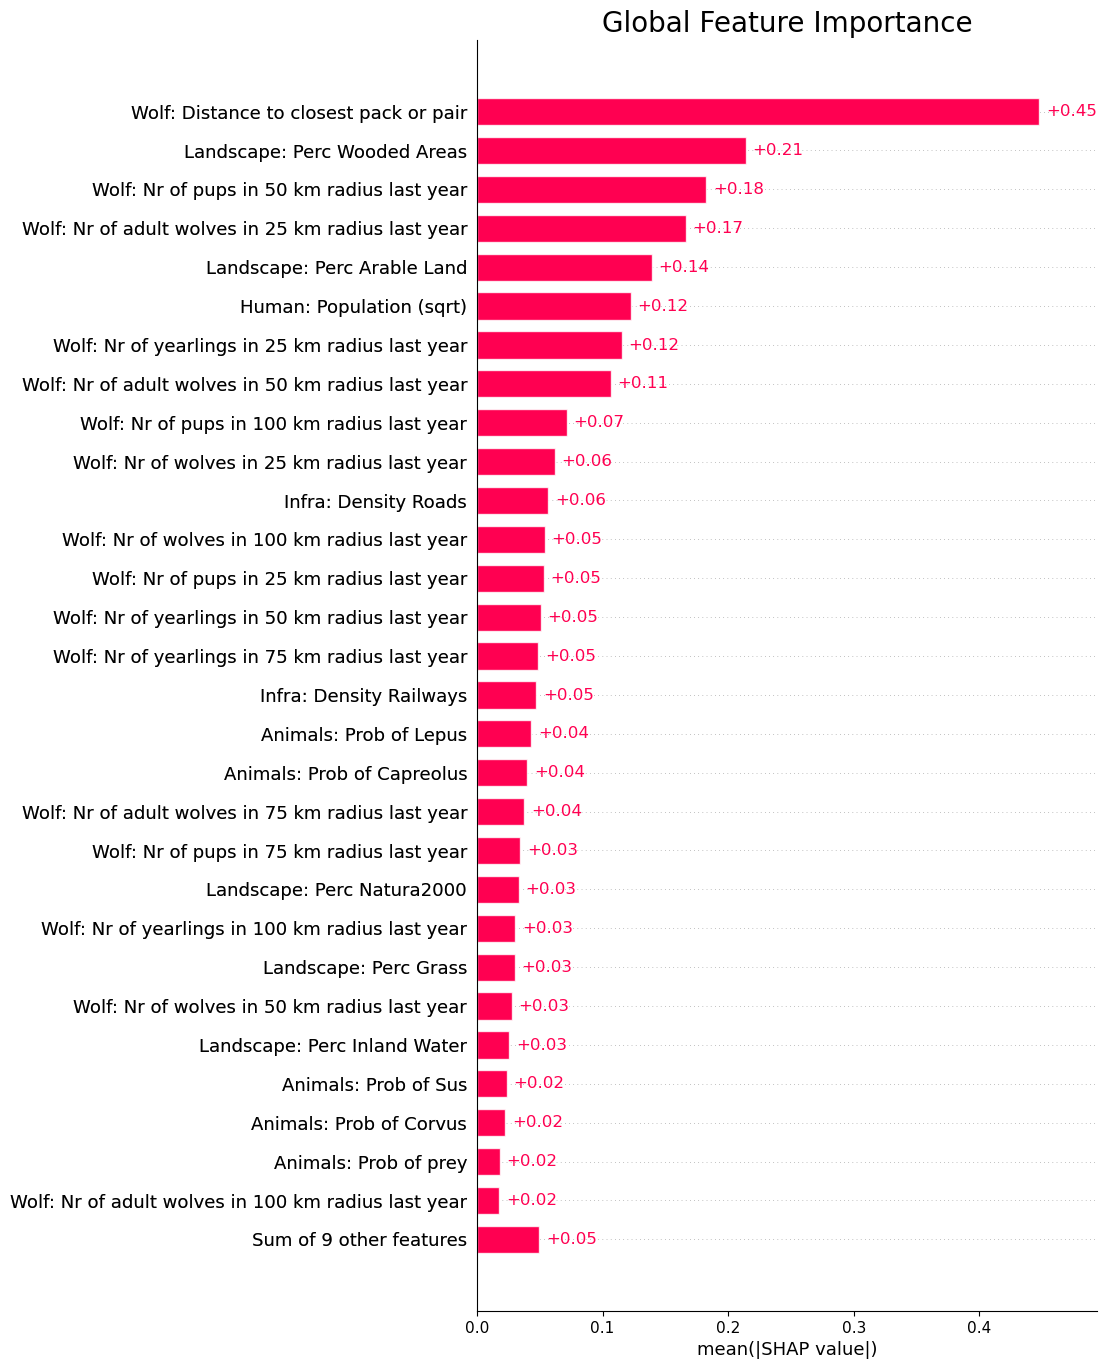

In [13]:
shap.plots.bar(shap_values, max_display=30, show=False)
plt.title('Global Feature Importance', fontsize=20)
plt.show()

The global feature importance is the mean absolute shap value for the feature over all records in the data. Put differently: What absolute impact has that feature on the probability of the area that a wolf pair will settle there? The higher the score, the more influence this characteristic has on this probability, either positive or negative.  

It is clear that **closeness to other pairs/packs** and **how many wolves are in a radius of the area** - with different radii - is very important in predicting settlement of pairs. How the variables exactly relate to our target, we'll see later on. 

Aside from other wolves, also 'human' **population** in the area is an important predictor. 

A third group of features that have high impact on the probabilities are about the configuration of the area: to what extent is it covered with **wooded areas**, are there **roads** and **rails** and whether the area is (partly) a **Natura 2000** zone.   

## *How* are predictors related to the probability of Wolves to Settle in the area?

Now whe know what features are important, the question that pops up immediately is: ***How?*** As a feature increases in value - more wolves in a radius, more habitants in the area - does the probability of wolf pairs to settle **increase** or **decrease**? And how much? SHAP has different ways to help us with that! 

Now we can use one of the most informative - yet also information-dense - plots SHAP has to offer: The **[beeswarm plot](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html)**. 

How to interpret the beeswarm plot: In the order of the feature importance, it both shows the distribution of the feature values and the correlation with the SHAP value. The distribution of feature values is shown in the color of the dots: *Blue* dots are observations with a *low value* on the feature (low number of wolves in radius, low population in area,... ) and *reds* are observations with a *high value* on the feature. The *horizontal location* of dots per feature represent the correlation with the SHAP value: *Left* from the y axis (negative SHAP values) represent *decrease* of the probability that wolf pairs settle in the area and positive SHAP values (*right* from the y axis) represent an *increased* probability; the further from the y axis, the bigger the impact. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


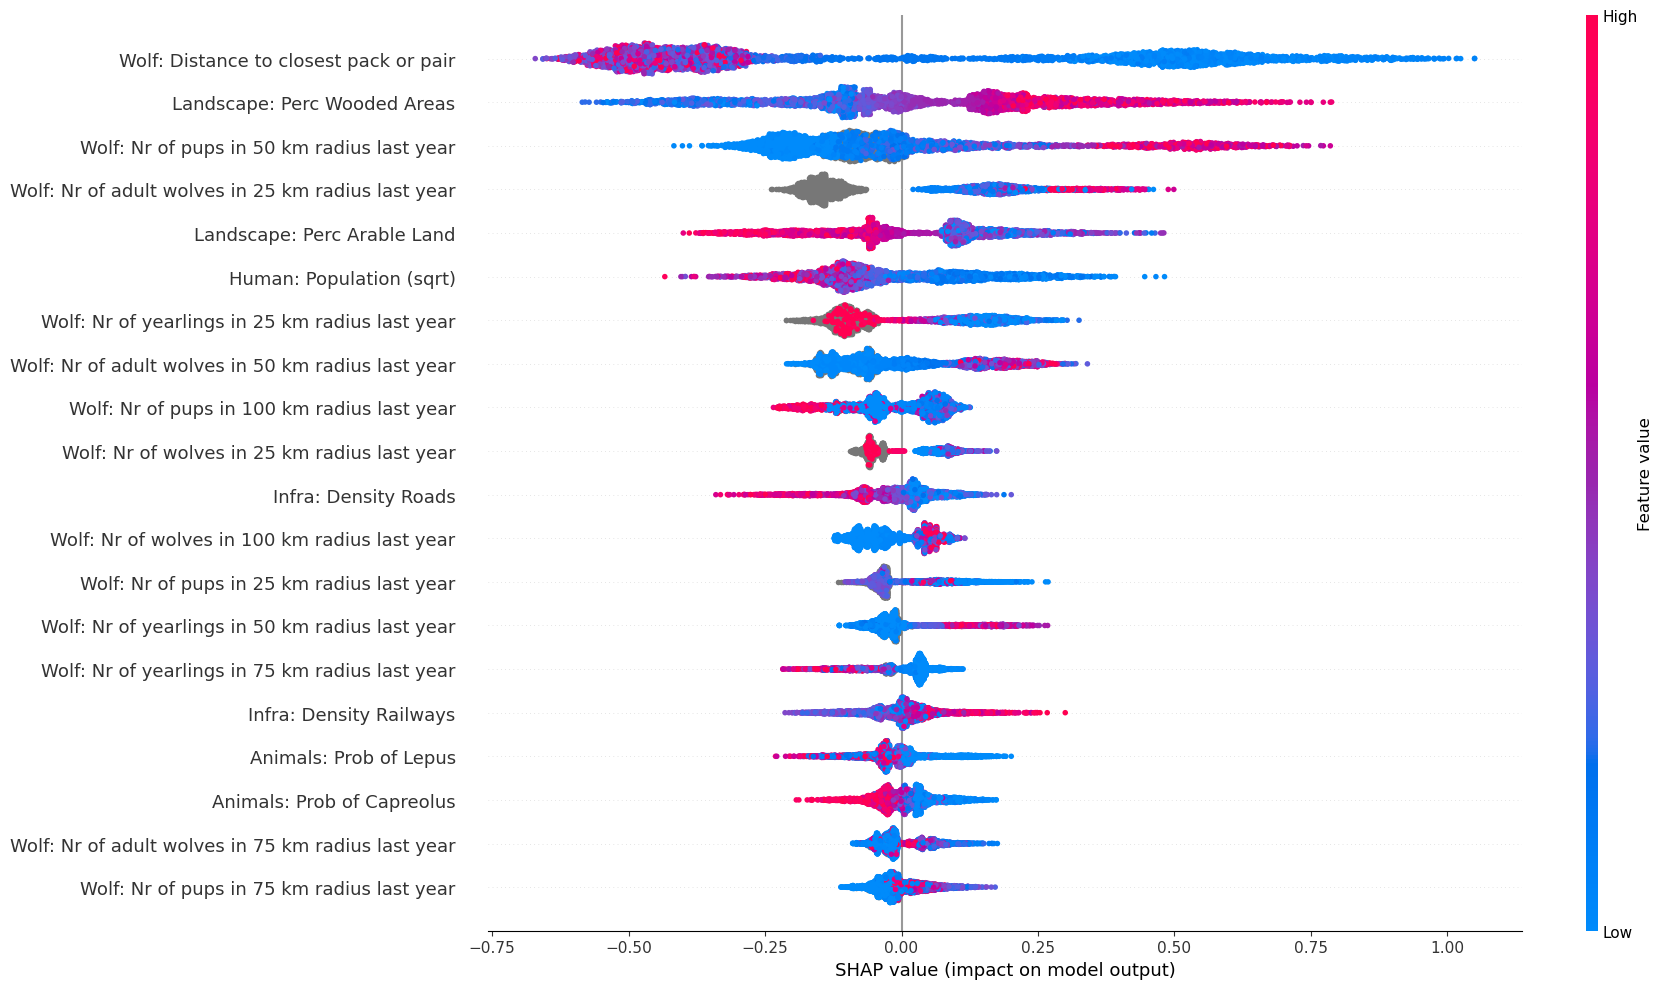

In [14]:
shap.summary_plot(shap_values, df[featcols], plot_type='dot', show=False, plot_size=[18,10])

We clearly see some features where high feature values (red) coincide with negative SHAP values - hence *decreased settlement probability*.  This goes for **distance to closest pair** and **human population**. 

On the other hand, there are some features with a strong *positive correlation* between feature value and probability to settle. The **number of adult wolves in 25km radius**, **amount of wooded land** and **railways** are good examples of that. For other features it's not immediately clear how the correlation is shaped. The next plots, per feature, might provide more in-depth insights.  

Let's have a closer look at some of the relationships between top features and probability for wolf pairs to settle in the area. 

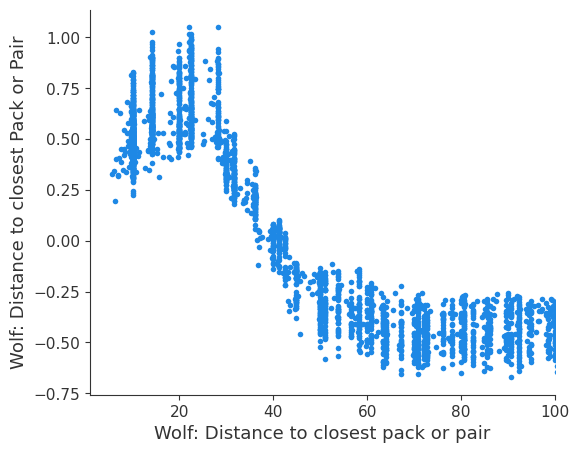

In [17]:
shap.dependence_plot(featcols.index('Wolf: Distance to closest pack or pair'), Tree_shap_values, df[featcols], interaction_index=None, xmax=100, show=False)
plt.ylabel("Wolf: Distance to closest Pack or Pair")
plt.show()

Interestingly, when the **distance to another pair or pack** is very low (hence another pair is very nearby), the likelihood of a new pair to settle is decreased (SHAP < 0). However, having a pair or pack with 20-40 kilometers does seem to increase the probability to settle. We could hypothesize that this is due to the offspring of the pack? Pups become yearlings and then adults, ready to start their own offspring. When the distance to a pair or pack increases further above 50 kilometers, the probability of settlement decreases. This might be due to chance of an encounter: Not that likely that an adult male and female meet in those areas, that far from existing settlements.

The dependence plot below for the **number of adult wolves in 25 km radius** is in line with this hypothesis: Other wolves nearby increase the likelihood males and females meeting and mating and starting a settlement. 

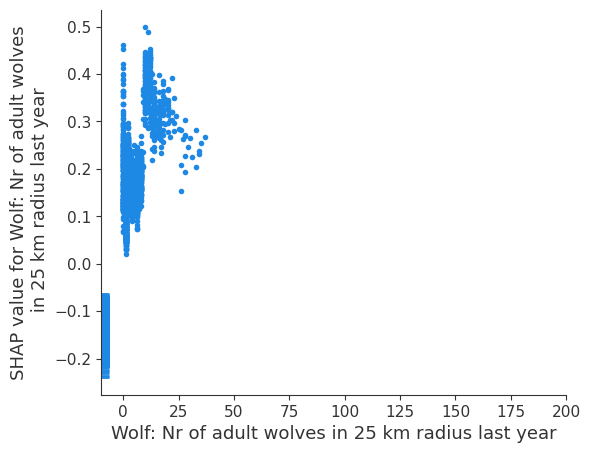

In [19]:
shap.dependence_plot(featcols.index('Wolf: Nr of adult wolves in 25 km radius last year'), Tree_shap_values, df[featcols], interaction_index=None,xmax=200, show=False)
plt.ylabel("SHAP value for Wolf: Nr of adult wolves\n in 25 km radius last year")
plt.show()

Aside from other wolves, we see that features about the area are quite predictive for wolf settlement. For instance the proportion of the area that is classified as **woodland** shows a strong positive relationship with settlement chance. It does seem to top off when more than 60% of the area is woodland. 

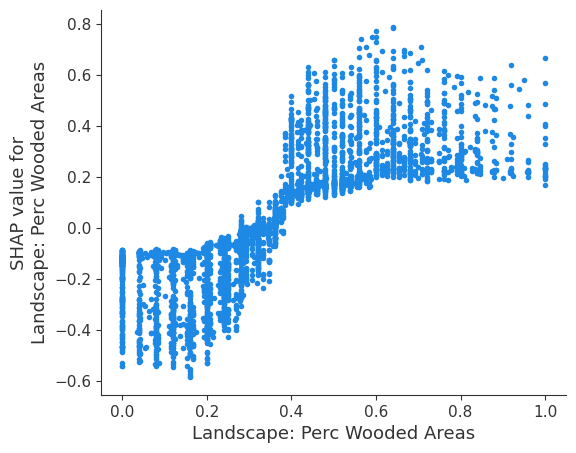

In [20]:
shap.dependence_plot(featcols.index('Landscape: Perc Wooded Areas'), Tree_shap_values, df[featcols], interaction_index=None, show=False)
plt.show()


A last feature we explore in more depth here is human presence: How is **human population** in the area related to settlement probability? As to be expected, less humans nearby increase the likelihood to settle and high (squared) populations correlate with lower probability for wolf pairs and packs to settle.

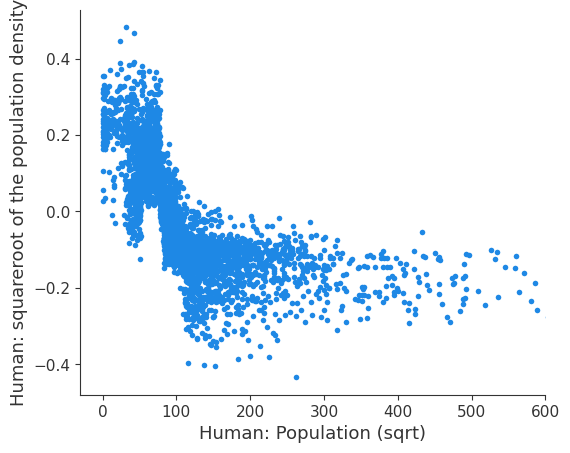

In [21]:
shap.dependence_plot(featcols.index('Human: Population (sqrt)'), Tree_shap_values, df[featcols], interaction_index=None, xmax=600, show=False)
plt.ylabel('Human: squareroot of the population density')
plt.show()

## Adjacent areas with very different probabilities for wolf presence, how come?

In our probability plot of wolf presence we see some regions with neighbouring areas that have very distinct probabilities according to our model. Of course our model is far from perfect, but still we are wondering if we can explain the difference in probabilities accoring to our model. For example we see an area with a high probability (e.g. '10kmE463N314': 84,5%) and an adjacent area with a very low probability (e.g. '10kmE462N313': 0,2%). With the shap waterfall plot, we can see what impact each feature has on the probability of an individual area. Let's do this for the exemplar high and low probability areas:   

In [24]:
df_probs = df.reset_index(drop=False)
lowprob_name = '10kmE462N313'
highprob_name = '10kmE463N314'
lowprob_idx = df_probs[df_probs.id == lowprob_name].index[0]
highprob_idx = df_probs[df_probs.id == highprob_name].index[0]


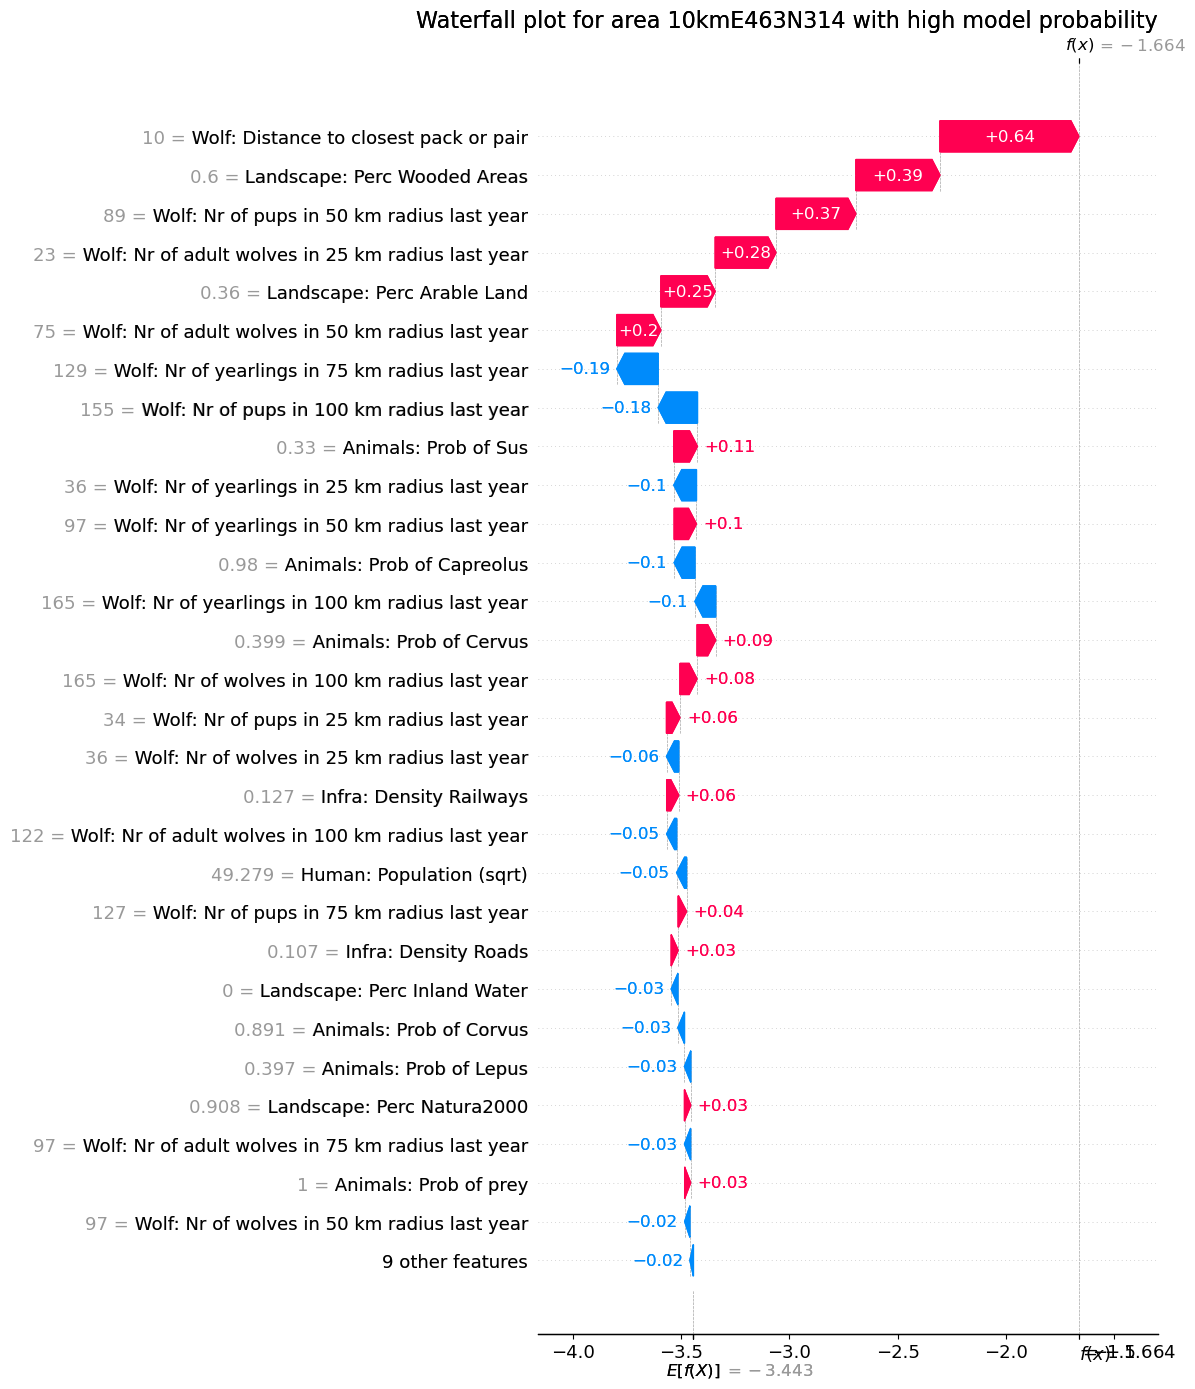

In [26]:
shap.plots.waterfall(shap_values[highprob_idx],max_display=30,show=False)
_ = plt.title(f'Waterfall plot for area {highprob_name} with high model probability', fontsize=16, loc='right')
plt.show()

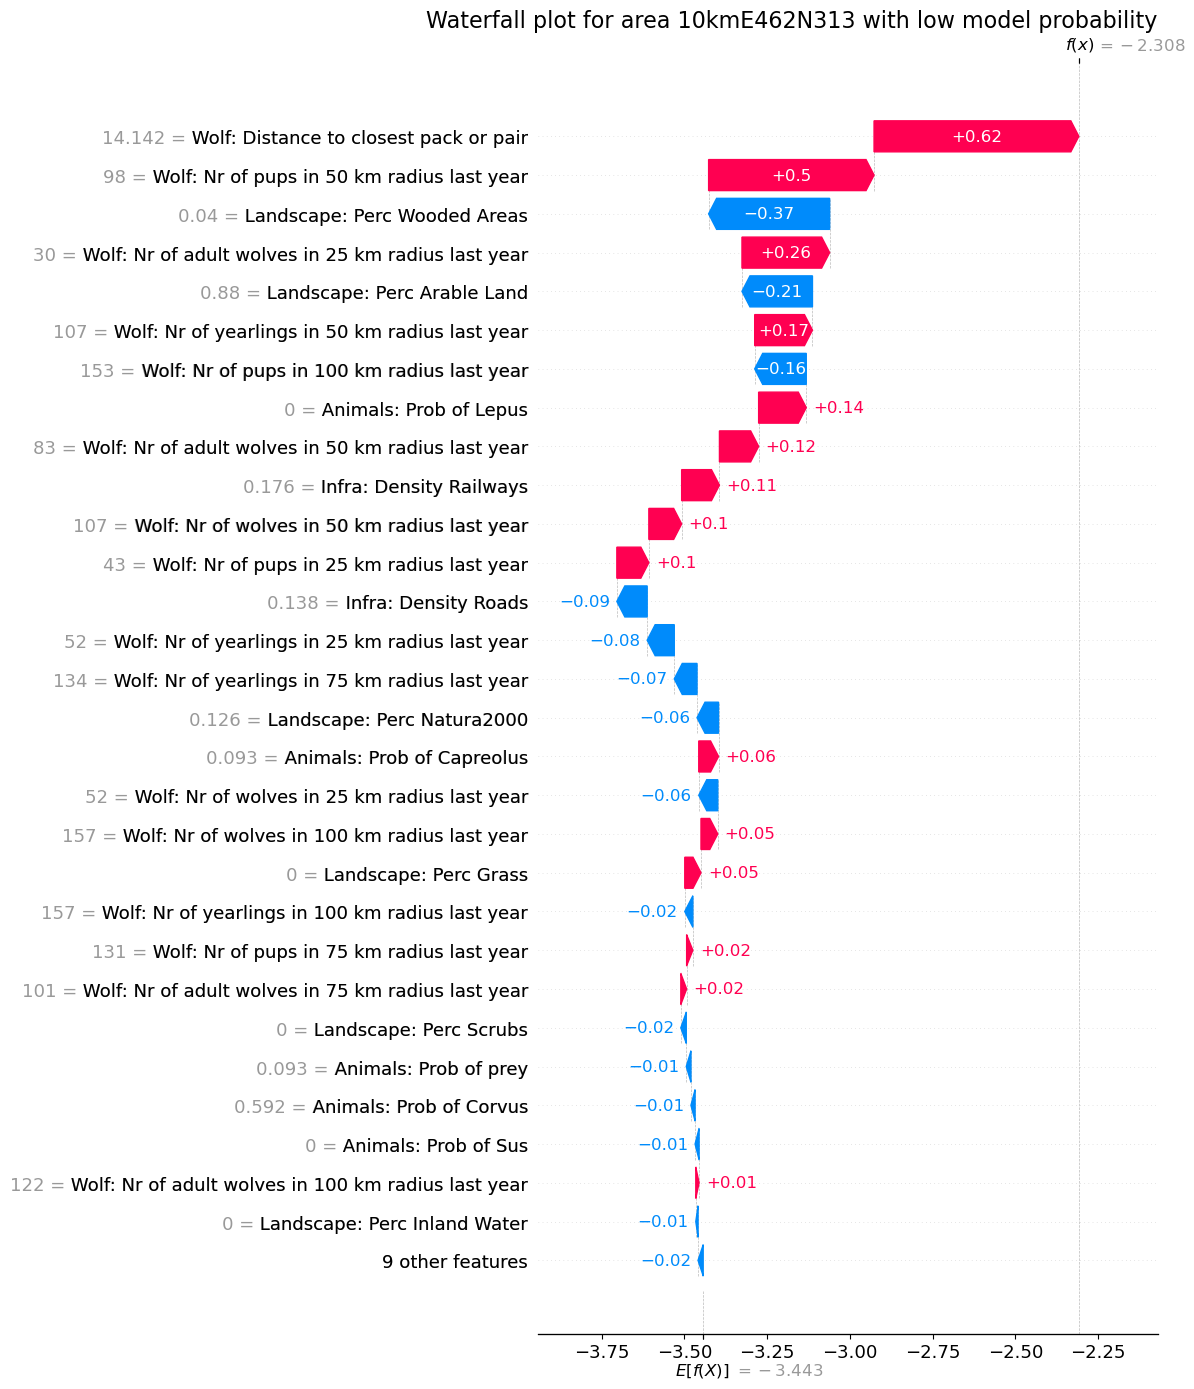

In [29]:
shap.plots.waterfall(shap_values[lowprob_idx],max_display=30,show=False)
_ = plt.title(f'Waterfall plot for area {lowprob_name} with low model probability', fontsize=16, loc='right')
plt.show()

By generating these waterfall plots for each of the areas, we can easily get an overview of the differences between these areas and get a feel for why the probability of wolf presence is so different even thought the areas are adjacent.

## Conclusions: What did we learn about wolf pair settlement?

In this blog, we hope we showed that SHAP is a valuable tool to shed light on a black box predictive model. It enabled us to interpret why the model expects some areas to be more attractive for wolves than other areas.